In [2]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional


sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('..'))


from src.agents.base_agent import BaseAgent
from src.env_sailing import SailingEnv
from src.initial_windfields import get_initial_windfield

In [8]:
class Agent(BaseAgent):
    def __init__(self, params: Optional[dict] = None):
        super().__init__()
    

    def act(self, observation: np.ndarray) -> int:
        """
        Given an observation, return an action.
        """
        # For this example, we will just return a random action
        return np.random.randint(0, 9)
    
    def reset(self) -> None:
        """Reset the agent's internal state.
        
        This method is called at the beginning of each episode.
        Override this method if your agent maintains internal state.
        """
        pass
    
    def seed(self, seed: Optional[int] = None) -> None:
        """Set the random seed for this agent.
        
        Args:
            seed: The random seed to use. If None, a random seed will be used.
        """
        self.np_random = np.random.default_rng(seed) 

### Run on the static windfielf

Running the naive agent on the simple_static initial windfield:
Step 50: Position=[7 4], Reward=0.0


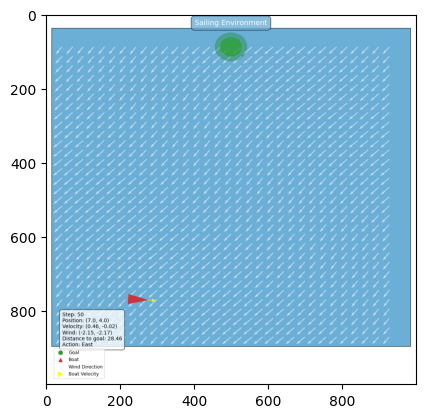

Step 100: Position=[1 3], Reward=0.0


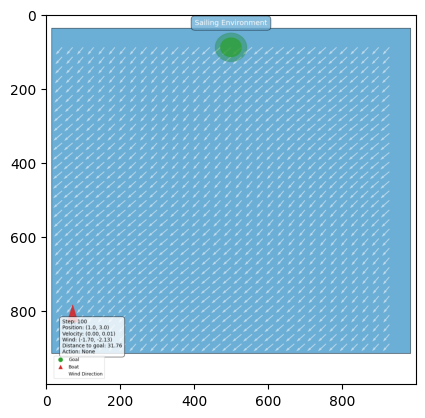

Step 150: Position=[1 0], Reward=0.0


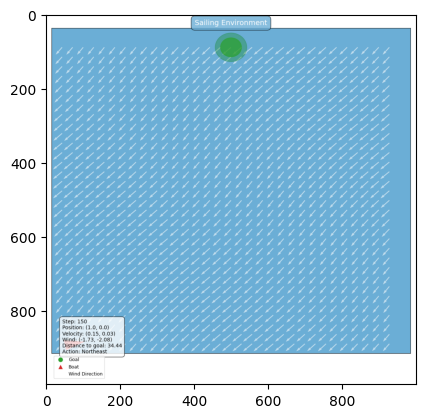

Step 200: Position=[0 0], Reward=0.0


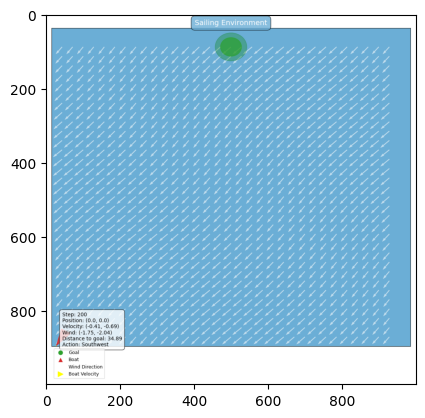


Episode finished after 200 steps with reward: 0.0
Final position: [0 0]
Goal reached: False


In [7]:
# Create an environment with a simple test initial windfield
env = SailingEnv(**get_initial_windfield('simple_static'))
agent = Agent()

# Run a single episode
observation, info = env.reset(seed=42)
total_reward = 0
done = False
truncated = False
step_count = 0

print("Running the naive agent on the simple_static initial windfield:")
while not (done or truncated) and step_count < 200:  # Limit to 100 steps
    action = agent.act(observation)
    observation, reward, done, truncated, info = env.step(action)
    total_reward += reward
    step_count += 1
    
    # Print every 10 steps to avoid too much output
    if step_count % 50 == 0:
        print(f"Step {step_count}: Position={info['position']}, Reward={reward}")
        plt.imshow(env.render())
        plt.show()

print(f"\nEpisode finished after {step_count} steps with reward: {total_reward}")
print(f"Final position: {info['position']}")
print(f"Goal reached: {done}")

## Train Agent

In [9]:
# Create our Q-learning agent for full training
params = {}
agent = Agent(params=params)

# Set fixed seed for reproducibility
np.random.seed(42)
agent.seed(42)

# Create environment with a simple initial windfield
env = SailingEnv(**get_initial_windfield('training_1'))

# Training parameters
num_episodes = 10  # More episodes for better learning
max_steps = 1000

# Progress tracking
rewards_history = []
steps_history = []
success_history = []

# Training loop
print("Starting full training with 100 episodes...")
import time
start_time = time.time()

for episode in range(num_episodes):
    # Reset environment and get initial state
    observation, info = env.reset(seed=episode)  # Different seed each episode
    state = agent.discretize_state(observation)
    
    total_reward = 0
    
    for step in range(max_steps):
        # Select action and take step
        action = agent.act(observation)
        next_observation, reward, done, truncated, info = env.step(action)
        next_state = agent.discretize_state(next_observation)
        
        # Update Q-table
        agent.learn(state, action, reward, next_state)
        
        # Update state and total reward
        state = next_state
        observation = next_observation
        total_reward += reward
        
        # Break if episode is done
        if done or truncated:
            break
    
    # Record metrics
    rewards_history.append(total_reward)
    steps_history.append(step+1)
    success_history.append(done)
    
    # Update exploration rate (decrease over time)
    agent.exploration_rate = max(0.05, agent.exploration_rate * 0.98)
    
    # Print progress every 10 episodes
    if (episode + 1) % 10 == 0:
        success_rate = sum(success_history[-10:]) / 10 * 100
        print(f"Episode {episode+1}/100: Success rate (last 10): {success_rate:.1f}%")

training_time = time.time() - start_time

# Calculate overall success rate
success_rate = sum(success_history) / len(success_history) * 100

print(f"\nTraining completed in {training_time:.1f} seconds!")
print(f"Success rate: {success_rate:.1f}%")
print(f"Average reward: {np.mean(rewards_history):.2f}")
print(f"Average steps: {np.mean(steps_history):.1f}")
print(f"Q-table size: {len(agent.q_table)} states")

Starting full training with 100 episodes...


AttributeError: 'Agent' object has no attribute 'discretize_state'

## Visualize

In [10]:
# Calculate rolling averages
window_size = 10
rolling_rewards = np.convolve(rewards_history, np.ones(window_size)/window_size, mode='valid')
rolling_steps = np.convolve(steps_history, np.ones(window_size)/window_size, mode='valid')
rolling_success = np.convolve([1 if s else 0 for s in success_history], np.ones(window_size)/window_size, mode='valid') * 100

# Create the plots
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Plot rewards
ax1.plot(rolling_rewards)
ax1.set_ylabel('Average Reward')
ax1.set_title('Training Progress (10-episode rolling average)')

# Plot steps
ax2.plot(rolling_steps)
ax2.set_ylabel('Average Steps')

# Plot success rate
#ax3.plot(rolling_success)
#ax3.set_ylabel('Success Rate (%)')
#ax3.set_xlabel('Episode')

plt.tight_layout()
plt.show()

ValueError: v cannot be empty

## Test

In [11]:
agent = Agent()

# Create test environment
test_env = SailingEnv(**get_initial_windfield('training_1'))

# Test parameters
num_test_episodes = 5
max_steps = 1000

print("Testing the trained agent on 5 new episodes...")
# Testing loop
for episode in range(num_test_episodes):
    # Reset environment
    observation, info = test_env.reset(seed=1000 + episode)  # Different seeds from training
    
    total_reward = 0
    
    for step in range(max_steps):
        # Select action using learned policy
        action = agent.act(observation)
        observation, reward, done, truncated, info = test_env.step(action)
        
        total_reward += reward
        
        # Break if episode is done
        if done or truncated:
            break
    
    print(f"Test Episode {episode+1}: Steps={step+1}, Reward={total_reward}, " +
          f"Position={info['position']}, Goal reached={done}")

Testing the trained agent on 5 new episodes...
Test Episode 1: Steps=1000, Reward=0.0, Position=[ 0 30], Goal reached=True
Test Episode 2: Steps=641, Reward=100.0, Position=[17 30], Goal reached=True
Test Episode 3: Steps=1000, Reward=0.0, Position=[ 0 15], Goal reached=True
Test Episode 4: Steps=567, Reward=100.0, Position=[15 30], Goal reached=True
Test Episode 5: Steps=1000, Reward=0.0, Position=[ 4 15], Goal reached=True
